In [5]:
import shutil, os, glob
for p in glob.glob('/content/*'): shutil.rmtree(p) if os.path.isdir(p) else os.remove(p)
print("✅ All files and directories under /content have been deleted.")

✅ All files and directories under /content have been deleted.


In [1]:
# 1) Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')          # follow the link → copy auth code → paste

# 2) OPTIONAL: quick sanity-check—show every merged*.csv in your CADeT tree
from pathlib import Path, PurePosixPath
for f in Path("/content/drive/MyDrive/CADeT/Data/Charged-1").rglob("merged*.csv"):
    print(PurePosixPath(f))

# 3) Continue with the violin-plot script
#    (make sure CSV_PATH matches one of the printed paths)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CADeT/Data/Charged-1/merged_data_m1.csv


## Data Access

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-726633132.py:44: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


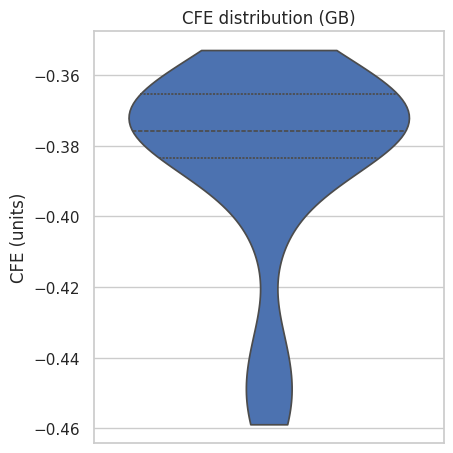

/tmp/ipython-input-726633132.py:44: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


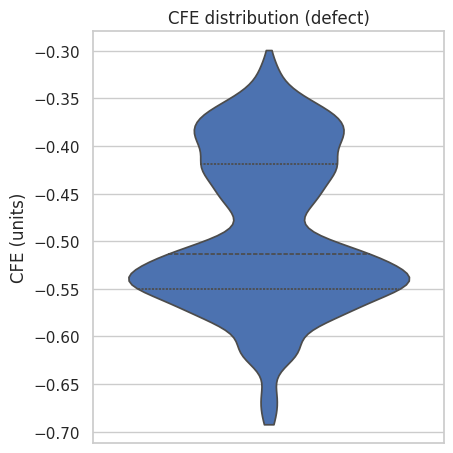

/tmp/ipython-input-726633132.py:44: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


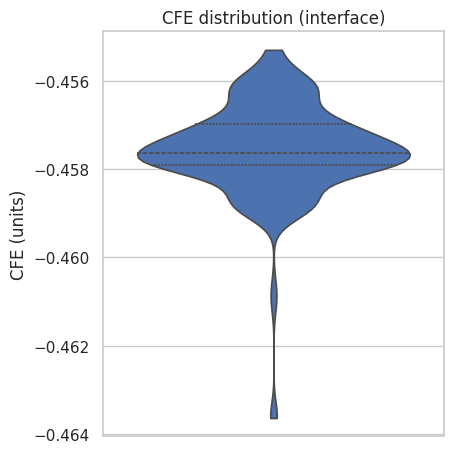

✅ CFE violin plots displayed for each Tag category.


In [5]:
# ── violin_CFE_by_tag.py ────────────────────────────────────────────────────
"""
Display a separate violin plot of CFE for every Tag category
(defect, interface, …) using dark fill colours.

Expected CSV columns (adjust if needed):
    Structure | Energy | Forces | Stress | Directory | Frequency | CFE | Tag
"""

# 0 ▸ Colab-only: mount Google Drive (comment out elsewhere) ─────────────────
try:
    from google.colab import drive            # noqa: F401
    drive.mount("/content/drive")
except ModuleNotFoundError:
    pass  # not running inside Colab

# 1 ▸ Imports ────────────────────────────────────────────────────────────────
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2 ▸ User settings ─────────────────────────────────────────────────────────
CSV_PATH  = Path("/content/drive/MyDrive/CADeT/Data/Charged-1/merged_data_m1.csv")
GROUP_COL = "Tag"          # column used to split the data (e.g. defect/interface)

# 3 ▸ Load & clean ───────────────────────────────────────────────────────────
df = pd.read_csv(CSV_PATH)
df["CFE"] = pd.to_numeric(df["CFE"], errors="coerce")  # ensure numeric

# 4 ▸ Global style ───────────────────────────────────────────────────────────
sns.set_theme(style="whitegrid", palette="deep", rc={"font.size": 22})

# 5 ▸ One violin per Tag category ────────────────────────────────────────────
categories = sorted(df[GROUP_COL].dropna().unique()) if GROUP_COL in df else [None]

for cat in categories:
    sub = df[(df[GROUP_COL] == cat) & df["CFE"].notna()]
    if sub.empty:
        continue

    fig, ax = plt.subplots(figsize=(5,5))

    sns.violinplot(
        data=sub,
        y="CFE",
        x=None,            # single violin
        scale="width",     # comparable width; y-range adapts to data
        inner="quartile",
        cut=0,
        saturation=1,      # dark fill (no pastel)
        ax=ax,
    )

    title_suffix = f" ({cat})" if cat is not None else ""
    ax.set_xlabel("")
    ax.set_ylabel("CFE (units)")
    ax.set_title(f"CFE distribution{title_suffix}")

    fig.tight_layout()
    plt.show()

print("✅ CFE violin plots displayed for each Tag category.")


### Access our MLFF Model

In [6]:
#!/usr/bin/env python3
"""
This script is specifically for Google Colab.
It automatically mounts Google Drive and uses the hard-coded path for the PES models.
It includes detailed logging for model loading to help debug path issues.
"""
import sys
import json
import shutil
import subprocess
import traceback
from itertools import product
from pathlib import Path

from google.colab import drive
import numpy as np
import pandas as pd
from pymatgen.core import Structure
from pymatgen.io.cif import CifWriter
from pymatgen.io.vasp import Poscar
from matgl import load_model
from matgl.ext.ase import Relaxer
from tqdm import tqdm

# --- Utility Functions (Unchanged) ---
def read_structure(p: Path) -> Structure:
    p = Path(p)
    ext = p.suffix.lower()
    if ext in (".cif", ".vasp") or p.name.upper() in ("POSCAR", "CONTCAR"):
        return Structure.from_file(p)
    if ext == ".xsf":
        tmp_cif = p.with_suffix(".cif")
        try:
            from ase.io import read, write
            write(str(tmp_cif), read(p))
            s = Structure.from_file(tmp_cif)
            tmp_cif.unlink()
            return s
        except Exception as e:
            print(f"Error converting {p}: {e}")
            if tmp_cif.exists(): tmp_cif.unlink()
            sys.exit("Could not convert XSF file. ASE library might be needed.")
    return Structure.from_file(p)

def get_central_atom_idx(struct: Structure, symbol: str) -> int:
    center_cart = struct.lattice.get_cartesian_coords([0.5, 0.5, 0.5])
    min_dist, site_idx = float('inf'), -1
    for i, site in enumerate(struct):
        if site.specie.symbol == symbol:
            dist = np.linalg.norm(site.coords - center_cart)
            if dist < min_dist: min_dist, site_idx = dist, i
    if site_idx < 0: raise ValueError(f"No atom with symbol '{symbol}' found in the structure.")
    return site_idx

def get_min_pbc_distance(struct: Structure, cart_coords: np.ndarray) -> float:
    frac_coords = struct.lattice.get_fractional_coords(cart_coords)
    min_dist = float('inf')
    for site in struct:
        fdist = frac_coords - site.frac_coords
        fdist -= np.round(fdist)
        dist = np.linalg.norm(struct.lattice.get_cartesian_coords(fdist))
        if dist < min_dist: min_dist = dist
    return float(min_dist)

def add_interstitial(struct: Structure, symbol: str):
    grid_points = np.linspace(0.3, 0.7, 9)
    best_pos, max_min_dist = None, -1.0
    for f_coords in product(grid_points, repeat=3):
        cart_coords = struct.lattice.get_cartesian_coords(f_coords)
        min_dist = get_min_pbc_distance(struct, cart_coords)
        if min_dist > max_min_dist: max_min_dist, best_pos = min_dist, cart_coords
    if best_pos is not None:
        struct.append(symbol, best_pos, coords_are_cartesian=True)
        return
    raise ValueError(f"Could not find a suitable site for interstitial '{symbol}'.")

def create_defect_structure(bulk_opt: Structure, defect_string: str) -> Structure:
    struct = bulk_opt.copy()
    for part in defect_string.split('+'):
        if part.startswith("V_"):
            symbol, idx = part[2:], get_central_atom_idx(struct, part[2:])
            struct.remove_sites([idx])
        elif part.endswith("_i"):
            add_interstitial(struct, part[:-2])
        elif '_' in part:
            src_symbol, dst_symbol = part.split('_')
            idx = get_central_atom_idx(struct, src_symbol)
            struct.replace(idx, dst_symbol)
        else: raise ValueError(f"Unknown defect type in string: '{part}'")
    return struct

# --- Main Script ---

def main():
    print("--- MGL Defect Energy Calculation (Google Colab Auto-Detect Version) ---")

    # --- 1. Connect to Google Drive and Verify Path ---
    print("\nConnecting to your Google Drive...")
    drive.mount('/content/drive', force_remount=True)

    model_base_path = Path("/content/drive/MyDrive/CADeT/PES")
    print(f"Checking for models at the fixed path: {model_base_path}")

    if not model_base_path.is_dir():
        print("❌ FATAL ERROR: The required model directory was not found.", file=sys.stderr)
        print(f"Please ensure this exact folder structure exists in your Google Drive: MyDrive -> CADeT -> PES", file=sys.stderr)
        sys.exit(1)

    print("✅ Models directory found!")

    bulk_path_str = input("\nEnter the FILENAME of your bulk structure (e.g., POSCAR): ").strip()
    defect_file_str = input("Enter the FILENAME of your defects list [default: Defects]: ").strip() or "Defects"

    bulk_path, defect_file = Path(bulk_path_str), Path(defect_file_str)

    if not bulk_path.is_file(): sys.exit(f"ERROR: Bulk file '{bulk_path}' not found. Please upload it.")
    if not defect_file.is_file(): sys.exit(f"ERROR: Defects file '{defect_file}' not found. Please upload it.")

    # --- 2. Load Models and Define Parameters ---
    charge_dirs = {+2: "pbe_p2", +1: "pbe_p1", 0: "pbe_neutral", -1: "pbe_m1", -2: "pbe_m2"}

    print("\nLoading MGL models...")
    relaxers = {}
    try:
        for q, d in charge_dirs.items():
            model_path = model_base_path / d
            print(f"  Attempting to load model for charge {q:+} from: {model_path}")
            relaxers[q] = Relaxer(load_model(model_path), relax_cell=False, optimizer="FIRE")

        # Load bulk relaxer separately
        bulk_model_path = model_base_path / "pbe_neutral"
        print(f"  Attempting to load bulk relaxer model from: {bulk_model_path}")
        bulk_relaxer = Relaxer(load_model(bulk_model_path), relax_cell=True, optimizer="FIRE")

    except Exception as e:
        print(f"❌ ERROR: Failed to load MGL models.", file=sys.stderr)
        print(f"The last attempted path was likely '{model_path}'.", file=sys.stderr)
        print("Please check the folder structure inside your Drive using the '!ls' command from Step 2.", file=sys.stderr)
        print(f"Original error: {e}", file=sys.stderr)
        sys.exit(1)

    print("✅ All models loaded successfully.")

    output_dir = Path("defects")

    # --- 3. Optimize Bulk Structure ---
    print("\n--- Optimizing Bulk Structure ---")
    bulk_initial = read_structure(bulk_path)
    with tqdm(total=1, desc="Bulk Relaxation") as pbar:
        bulk_res = bulk_relaxer.relax(bulk_initial.copy(), fmax=1e-5, steps=1)
        pbar.update(1)
    bulk_opt = bulk_res["final_structure"]
    E_bulk = float(bulk_res["trajectory"].energies[-1])
    print(f"Bulk optimization complete. Final Energy: {E_bulk:.6f} eV")

    bulk_out_dir = output_dir / "bulk"
    bulk_out_dir.mkdir(parents=True, exist_ok=True)
    Poscar(bulk_opt).write_file(bulk_out_dir / "POSCAR_opt")
    # ... rest of the script is unchanged ...
    CifWriter(bulk_opt).write_file(bulk_out_dir / "bulk_opt.cif")
    with open(bulk_out_dir / "energy_trajectory.json", "w") as f:
        json.dump([float(e) for e in bulk_res["trajectory"].energies], f, indent=2)
    print(f"Optimized bulk structure saved in '{bulk_out_dir}'")

    # --- 4. Process Defects ---
    with open(defect_file) as f:
        defect_lines = [line.strip() for line in f if line.strip() and not line.startswith('#')]
    results = []
    print(f"\n--- Processing {len(defect_lines)} Defects ---")
    for defect_string in tqdm(defect_lines, desc="Total Defects Progress"):
        tag = defect_string.replace('+', '_')
        tqdm.write(f"\nProcessing defect: {defect_string} (tag: {tag})")
        try:
            struct_initial_defect = create_defect_structure(bulk_opt, defect_string)
            struct_initial_defect.perturb(0.01)
        except ValueError as e:
            tqdm.write(f"  [ERROR] Could not create defect '{defect_string}': {e}")
            results.append({"Defect": defect_string, "E_bulk": E_bulk, "Error": str(e)})
            continue
        defect_row = {"Defect": defect_string, "E_bulk": E_bulk}
        for q, relaxer in sorted(relaxers.items()):
            charge_dir = output_dir / tag / f"q{q:+d}"
            charge_dir.mkdir(parents=True, exist_ok=True)
            try:
                res = relaxer.relax(struct_initial_defect.copy(), fmax=1e-5, steps=1)
                final_energy = float(res["trajectory"].energies[-1])
                defect_row[f"E({q:+d})"] = final_energy
                tqdm.write(f"  - Charge {q:+d}: Relaxed Energy = {final_energy:.6f} eV")
                CifWriter(res["final_structure"]).write_file(charge_dir / f"{tag}_q{q:+d}_opt.cif")
                with open(charge_dir / "energy_trajectory.json", "w") as f:
                    json.dump([float(e) for e in res["trajectory"].energies], f, indent=2)
            except Exception:
                tqdm.write(f"  - Charge {q:+d}: [ERROR] Relaxation failed.")
                traceback.print_exc(file=sys.stdout)
                defect_row[f"E({q:+d})"] = "error"
        results.append(defect_row)

    # --- 5. Finalize and Save Summary CSV ---
    print("\n--- Finalizing Results ---")
    charge_cols = [f"E({q:+d})" for q in sorted(charge_dirs, reverse=True)]
    base_cols = ["Defect", "E_bulk"]
    df = pd.DataFrame(results)
    for col in base_cols + charge_cols:
        if col not in df.columns: df[col] = ''
    existing_cols, final_cols = df.columns.tolist(), base_cols.copy()
    for c in charge_cols:
        if c in existing_cols: final_cols.append(c)
    for c in existing_cols:
        if c not in final_cols: final_cols.append(c)
    df = df[final_cols]
    output_csv = "optimisation_results.csv"
    df.to_csv(output_csv, index=False, float_format="%.6f")
    print(f"\nSummary of results written to '{output_csv}'")
    print("You can download all result files from the Colab file browser on the left.")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.11/dist-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


FileNotFoundError: Cannot find DGL C++ graphbolt library at /usr/local/lib/python3.11/dist-packages/dgl/graphbolt/libgraphbolt_pytorch_2.4.0.so

### Visualize the energy landscape

In [28]:
# ──────────────────────────────────────────────────────────────────────────
# USER-EDITABLE SETTINGS
# ──────────────────────────────────────────────────────────────────────────
BASE_DIR      = "defects"        # folder containing V_Cd/, V_Te/, …
OUTPUT_DIR    = "opt_plots"     # where the PNGs will be written
FIG_SIZE      = (6, 4)          # inches
FONT_SIZE     = 18
DPI           = 300             # PNG resolution
BAR_ALPHA     = 0.9
# ──────────────────────────────────────────────────────────────────────────
# NO CHANGES NEEDED BELOW THIS LINE
# ──────────────────────────────────────────────────────────────────────────

from pathlib import Path
import json, re, os
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family"     : "Arial Narrow",
    "axes.labelsize"  : FONT_SIZE,
    "xtick.labelsize" : FONT_SIZE,
    "ytick.labelsize" : FONT_SIZE,
})

# colour palette
CHARGE_COLS = {
    +2 : "tab:orange",
    +1 : "tab:blue",
     0 : "tab:green",
    -1 : "tab:red",
    -2 : "tab:purple",
}

def load_trajectory(json_path):
    """Return a list of energies from energy_trajectory.json."""
    try:
        with open(json_path) as f:
            data = json.load(f)
        # support list OR dict storage
        if isinstance(data, list):
            return data
        if isinstance(data, dict):
            for key in ("energy", "energies", "E", "trajectory"):
                if key in data:
                    return data[key]
    except Exception as exc:
        print(f"⚠️  Could not read {json_path}: {exc}")
    return []

# ensure output dir exists
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

base_path = Path(BASE_DIR)
if not base_path.is_dir():
    raise FileNotFoundError(f"Base directory '{BASE_DIR}' not found.")

# ── loop over defect folders ───────────────────────────────────────────
for defect_dir in sorted(d for d in base_path.iterdir() if d.is_dir()):
    defect_name = defect_dir.name
    series_data = []

    # ── Collect and sort charge-state directories for a specific legend order ──
    charge_state_dirs = []
    for sub in defect_dir.iterdir():
        if not sub.is_dir():
            continue
        # Match subdirectories named "q<charge>", e.g., "q+2", "q-1", "q0"
        m = re.match(r"q([+-]?\d+)", sub.name)
        if m:
            q = int(m.group(1))
            charge_state_dirs.append((q, sub))

    # Sort by charge in descending order (+2, +1, 0, -1, -2) for plotting
    charge_state_dirs.sort(key=lambda item: item[0], reverse=True)

    # ── Load trajectory data from the sorted directories ───────────────────────
    for q, sub_dir in charge_state_dirs:
        json_path = sub_dir / "energy_trajectory.json"
        if json_path.is_file():
            colour = CHARGE_COLS.get(q, "black")
            label = f"q = {q:+d}"
            series_data.append((label, colour, load_trajectory(json_path)))

    # skip if nothing to plot
    if not series_data:
        print(f"⚠️  No trajectories found in {defect_name}")
        continue

    # ── make the optimisation-history plot ────────────────────────────
    plt.figure(figsize=FIG_SIZE)
    for label, colour, energies in series_data:
        if not energies:
            continue
        steps = np.arange(1, len(energies) + 1)
        plt.plot(steps, energies, lw=1.8, color=colour, label=label)

    plt.title(defect_name, pad=6)
    plt.xlabel("Optimisation step")
    plt.ylabel("Energy (eV)")
    plt.legend(loc="best", frameon=False, fontsize=FONT_SIZE - 2)
    plt.tight_layout()

    fname = Path(OUTPUT_DIR) / f"{defect_name}.png"
    plt.savefig(fname, dpi=DPI)
    plt.close()

    print(f"✓  Saved {fname}")

print("\nAll optimisation-history plots finished.")

✓  Saved opt_plots/Cd_i.png


✓  Saved opt_plots/Te_i.png


✓  Saved opt_plots/V_Cd.png


✓  Saved opt_plots/V_Te.png
⚠️  No trajectories found in bulk

All optimisation-history plots finished.


### Calculate Chemical Potential

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
#  Chemical-potential analysis for CdTe (doped ≥ v0.10)
# ─────────────────────────────────────────────────────────────────────────────

# !pip install --upgrade doped pymatgen monty   # ← uncomment in Colab if needed

from pathlib import Path
import pandas as pd
from doped.chemical_potentials import CompetingPhasesAnalyzer
from pymatgen.ext.matproj import MPRester
from monty.serialization import dumpfn

# ---------------------------------------------------------------------------
# 1. Locate all vasprun.xml files you want to include
# ---------------------------------------------------------------------------
BASE_DIR = Path("/content/drive/MyDrive/CADeT/CompetingPhases")   # adjust if needed
vasprun_list = [
    str((sub / "vasprun.xml").resolve())
    for sub in BASE_DIR.iterdir()
    if not sub.name.startswith(".") and (sub / "vasprun.xml").is_file()
]

print(f"✅ Found {len(vasprun_list)} vasprun.xml files")
if not vasprun_list:
    raise RuntimeError("No vasprun.xml files found – check BASE_DIR path!")

# ---------------------------------------------------------------------------
# 2. Build the analyser *with that list* (constructor parses them right away)
# ---------------------------------------------------------------------------
formula = "CdTe"
cpa = CompetingPhasesAnalyzer(formula, vasprun_list)   # ← key change

# ---------------------------------------------------------------------------
# 3. Calculate chemical-potential limits and save to CSV
# ---------------------------------------------------------------------------
chempot_df = cpa.calculate_chempots()
csv_name = f"{formula}_chempots.csv"
chempot_df.to_csv(csv_name, index=False)
print(f"📄 Saved chemical-potential table to {csv_name}")

# ---------------------------------------------------------------------------
# 4. OPTIONAL – recreate an analyser from Materials Project entries
# ---------------------------------------------------------------------------
API_KEY = "BufWkEdSbFdTyDSR2uHiNW3YTqrUJ73i"           # legacy API key
with MPRester(API_KEY) as mpr:
    mp_entries = mpr.get_entries_in_chemsys(["Cd", "Se", "Te"])

cpa_mp = CompetingPhasesAnalyzer(formula, mp_entries)
dumpfn(cpa_mp, f"{formula}_competing_phases.json")
print(f"💾 Saved MP-based analyser to {formula}_competing_phases.json")

# ---------------------------------------------------------------------------
# 5. Quick sanity check
# ---------------------------------------------------------------------------
print("\n--- Chemical-potential limits (eV) ---")
print(chempot_df)


✅ Found 3 vasprun.xml files


Parsing vaspruns...: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Calculated chemical potential limits (in eV wrt elemental reference phases): 

              Cd       Te
Limit                    
CdTe-Cd  0.00000 -0.72745
CdTe-Te -0.72745  0.00000
📄 Saved chemical-potential table to CdTe_chempots.csv
💾 Saved MP-based analyser to CdTe_competing_phases.json

--- Chemical-potential limits (eV) ---
              Cd       Te
Limit                    
CdTe-Cd  0.00000 -0.72745
CdTe-Te -0.72745  0.00000


In [ ]:
#!/usr/bin/env python3
"""
-----------------------------------------------------------------
CHEMICAL-POTENTIAL TABLE  (native + optional impurities)
-----------------------------------------------------------------
• Reads the Δμ‐table produced by CompetingPhasesAnalyzer
• Adds absolute μ_i = Δμ_i + E_ref(i)
• Generates the list of native defects (+ impurity variants, if requested)
• For every growth condition, evaluates the μ that enters
      V_X   : μ(X)
      X_Y   : μ(Y) − μ(X)
      X_i   : –μ(X)
  and writes the results to  defect_mu_table.csv
-----------------------------------------------------------------
The output format is now "wide":

Defect    , Condition_1, Condition_2, ...
-----------------------------------------
V_Cd      , -1.23      , -1.95      , ...
V_Te      , -4.25      , -3.52      , ...
Cd_Te     ,  3.02      ,  1.56      , ...
...
-----------------------------------------------------------------
"""

import pandas as pd
from pathlib import Path
from pymatgen.io.vasp import Vasprun
from pymatgen.core.composition import Composition

# ---------- STEP 1: user input ----------------------------------------------
compound  = input("Compound formula (e.g. CdTe): ").strip()
csv_file  = input("Δμ CSV file           : ").strip()

add_imp   = input("Consider impurities?  (y/n): ").strip().lower() == "y"
impurities = []
if add_imp:
    impurities = [el.strip() for el in input("Impurity element(s) (e.g. Cl,O): ").split(",")]

# ---------- STEP 2: read Δμ table -------------------------------------------
try:
    Δμ_df = pd.read_csv(csv_file)
    print("\nΔμ table read successfully:\n", Δμ_df)
except FileNotFoundError:
    print(f"Error: The file '{csv_file}' was not found.")
    exit()


# ---------- STEP 3: reference energies --------------------------------------
def E_ref(el):
    """Safely reads reference energy from a vasprun.xml file."""
    filepath = Path(f"/content/drive/MyDrive/CADeT/CompetingPhases/{el}/vasprun.xml")
    try:
        vr = Vasprun(filepath)
        return vr.final_energy / vr.final_structure.num_sites
    except Exception as e:
        print(f"Error: Could not read or parse {filepath}. Please ensure it exists and is a valid vasprun.xml file.")
        print(f"Details: {e}")
        exit()

elements = [str(el) for el in Composition(compound).elements]
E_ref_dict = {el: E_ref(el) for el in elements + impurities}
print("\n" + "="*30)
for el, E in E_ref_dict.items():
    print(f"E_ref({el}) = {E:.6f} eV/atom")
print("="*30)

# ---------- STEP 4: absolute μ columns --------------------------------------
for el in elements + impurities:
    if el in Δμ_df.columns:
        Δμ_df[f"mu_{el} (eV)"] = Δμ_df[el] + E_ref_dict[el]

# ---------- STEP 5: enumerate defects ---------------------------------------
defects = []
# native
for el in elements:
    defects.append(f"V_{el}")
for el1 in elements:
    for el2 in elements:
        if el1 != el2:
            defects.append(f"{el1}_{el2}")
for el in elements:
    defects.append(f"{el}_i")
# impurities
for imp in impurities:
    defects.append(f"{imp}_i")
    for host in elements:
        defects.append(f"{imp}_{host}")

# Ensure unique defect list in a specific order
defects = sorted(list(set(defects)))
print("\nDefect list:", defects)

# ---------- STEP 6: build and reshape the table -----------------------------
rows = []
for idx, row in Δμ_df.iterrows():
    # Use the 'Limit' column if it exists, otherwise create a generic name
    cond = row.get("Limit", f"Condition_{idx+1}")
    for d in defects:
        parts = d.split("_")
        if d.startswith("V_"):
            el  = parts[1]
            μ   = row.get(f"mu_{el} (eV)", float("nan"))
        elif d.endswith("_i"):
            el  = parts[0]
            μ0  = row.get(f"mu_{el} (eV)", float("nan"))
            μ   = -μ0
        else:   # antisite / impurity substitution
            src, dst = parts   # X_Y means X on Y site, so μ is for Y-X
            μ_src = row.get(f"mu_{src} (eV)", float("nan"))
            μ_dst = row.get(f"mu_{dst} (eV)", float("nan"))
            μ     = μ_dst - μ_src
        rows.append(dict(Condition=cond, Defect=d, mu_eV=μ))

# Create the initial "long" DataFrame
long_df = pd.DataFrame(rows)

# --- MODIFICATION START: Pivot from long to wide format ---
print("\nPivoting table to wide format...")
# Use pivot to reshape the data
# index='Defect' -> each unique defect gets its own row
# columns='Condition' -> each unique condition becomes a column
# values='mu_eV' -> the cells are filled with the chemical potential values
wide_df = long_df.pivot(index='Defect', columns='Condition', values='mu_eV')

# The 'Defect' column is now the index. To make it a regular column, use reset_index()
wide_df = wide_df.reset_index()

# Remove the name of the columns axis ('Condition'), which is good practice after a pivot
wide_df.columns.name = None
# --- MODIFICATION END ---

# Save the new wide DataFrame
wide_df.to_csv("defect_mu_table.csv", index=False, float_format="%.6f")
print("\n✅ defect_mu_table.csv written in WIDE format.")
print(wide_df.head())

Compound formula (e.g. CdTe): CdTe
Δμ CSV file           : CdTe_chempots.csv
Consider impurities?  (y/n): n

Δμ table read successfully:
         Cd       Te
0  0.00000 -0.72745
1 -0.72745  0.00000

E_ref(Cd) = -1.231819 eV/atom
E_ref(Te) = -3.524282 eV/atom

Defect list: ['Cd_Te', 'Cd_i', 'Te_Cd', 'Te_i', 'V_Cd', 'V_Te']

Pivoting table to wide format...

✅ defect_mu_table.csv written in WIDE format.
  Defect  Condition_1  Condition_2
0  Cd_Te    -3.019913    -1.565013
1   Cd_i     1.231819     1.959269
2  Te_Cd     3.019913     1.565013
3   Te_i     4.251732     3.524282
4   V_Cd    -1.231819    -1.959269


--- Defect Formation Energy Diagram Generator ---
✓ Successfully loaded data files.
Enter compound formula for plot title (e.g., CdTe): CdTe
Enter the band gap Eg (eV): 1.5
Enter the Valence Band Maximum VBM (eV): 1.83

--- Select a Growth Condition ---
  1) Condition_1
  2) Condition_2
Enter the number of the condition to use [1-2]: 1
✓ Using condition: Condition_1

--- Select Defects to Plot ---
  1) V_Cd
  2) V_Te
Enter defect names or numbers, separated by commas (e.g., 1,V_Te,3 or all).
Your selection: 1
✓ Selected defects for plotting: V_Cd

--- Calculating Formation Energies ---
✓ Formation energy data written to defect_formations.xlsx
✓ Generating plot...
✓ Diagram saved to CdTe_Condition_1_diagram.png


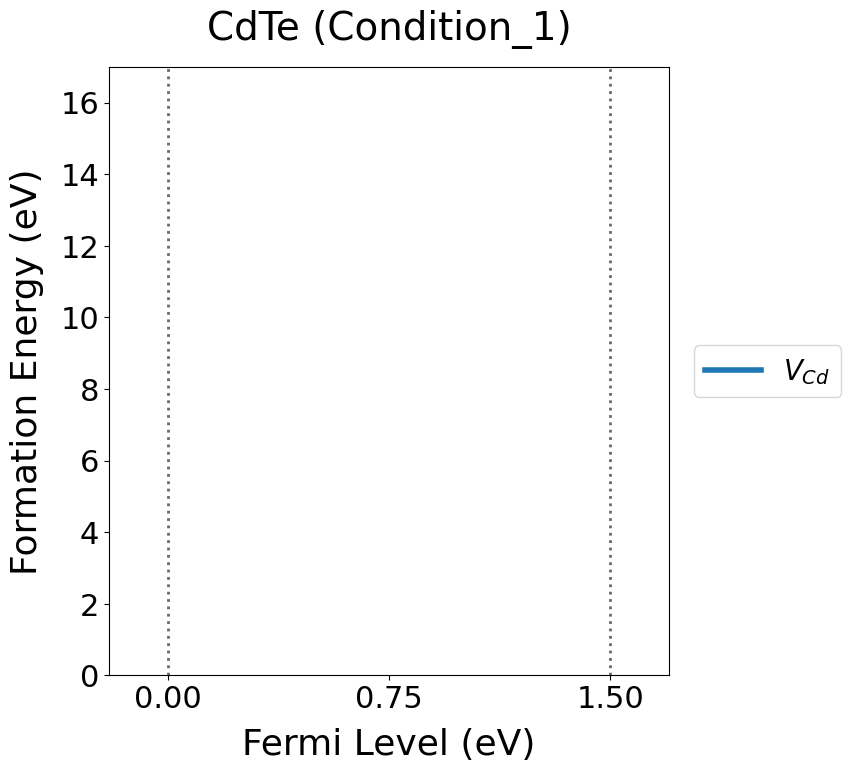

In [ ]:
#!/usr/bin/env python3
"""
Formation-energy diagram (minimum-energy envelope)
--------------------------------------------------
Reads the "wide" format CSV files generated by the previous scripts
and interactively prompts the user to select the growth condition
and which defects to plot.

Requires (in current directory):
  optimisation_results.csv      (Wide format: Defect, E_bulk, E(+2), E(+1)...)
  defect_mu_table.csv           (Wide format: Defect, Condition_1, Condition_2...)

Outputs:
  defect_formations.xlsx        Numeric table of formation energies for the selected defects.
  <compound>_<condition>_diagram.png
"""

import sys
from pathlib import Path
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Helper Functions ---
def parse_charge_from_col(col_name):
    """Extracts integer charge from column names like 'E(+2)' or 'E(-1)'."""
    match = re.search(r'E\(([+-]?\d+)\)', col_name)
    if match:
        return int(match.group(1))
    return None

def format_defect_label(tag):
    """Formats a defect tag string for a Matplotlib plot label with subscripts."""
    if '_' in tag:
        # Split only on the first underscore
        parts = tag.split('_', 1)
        # Use a raw f-string for proper LaTeX-like formatting
        return fr'${parts[0]}_{{{parts[1]}}}$'
    return tag # Return the original tag if no underscore

# --- 1. File and Data Loading ---
print("--- Defect Formation Energy Diagram Generator ---")

# File paths
csv_opt = Path("optimisation_results.csv")
csv_mu = Path("defect_mu_table.csv")

for p in (csv_opt, csv_mu):
    if not p.is_file():
        sys.exit(f"❌ FATAL: Missing required file: {p}")

# Load data into pandas DataFrames
try:
    opt_df = pd.read_csv(csv_opt)
    mu_df = pd.read_csv(csv_mu)
    print("✓ Successfully loaded data files.")
except Exception as e:
    sys.exit(f"❌ FATAL: Could not read CSV files. Error: {e}")

# --- 2. Interactive User Prompts ---

# Basic parameters
compound = input("Enter compound formula for plot title (e.g., CdTe): ").strip()
gap = float(input("Enter the band gap Eg (eV): ").strip())
vbm_val = float(input("Enter the Valence Band Maximum VBM (eV): ").strip())

# Select Growth Condition from mu_table.csv
available_conditions = [c for c in mu_df.columns if c != 'Defect']
if not available_conditions:
    sys.exit("❌ FATAL: No conditions found in defect_mu_table.csv (columns other than 'Defect').")

print("\n--- Select a Growth Condition ---")
for i, cond in enumerate(available_conditions, 1):
    print(f"  {i}) {cond}")
choice = input(f"Enter the number of the condition to use [1-{len(available_conditions)}]: ").strip()
try:
    cond_idx = int(choice) - 1
    if not 0 <= cond_idx < len(available_conditions):
        raise ValueError
    selected_condition = available_conditions[cond_idx]
    print(f"✓ Using condition: {selected_condition}")
except (ValueError, IndexError):
    sys.exit("❌ FATAL: Invalid selection.")

# Robust Defect Selection
available_defects = opt_df['Defect'].tolist()
print("\n--- Select Defects to Plot ---")
for i, defect in enumerate(available_defects, 1):
    print(f"  {i}) {defect}")
print("Enter defect names or numbers, separated by commas (e.g., 1,V_Te,3 or all).")
choice = input("Your selection: ").strip().lower()

selected_defects = []
if choice == 'all':
    selected_defects = available_defects
else:
    defect_lookup = {d.lower(): d for d in available_defects}
    for i, d in enumerate(available_defects, 1):
        defect_lookup[str(i)] = d

    user_inputs = [item.strip() for item in choice.split(',')]
    try:
        for item in user_inputs:
            found_defect = defect_lookup.get(item)
            if found_defect:
                if found_defect not in selected_defects:
                    selected_defects.append(found_defect)
            else:
                raise ValueError(f"Input '{item}' is not a valid defect name or number.")
    except ValueError as e:
        sys.exit(f"❌ FATAL: Invalid selection. {e}")

print(f"✓ Selected defects for plotting: {', '.join(selected_defects)}")


# --- 3. Prepare Data for Plotting ---
E_bulk = opt_df['E_bulk'].iloc[0]
mu_dict = mu_df.set_index('Defect')[selected_condition].to_dict()
charge_cols = {col: parse_charge_from_col(col) for col in opt_df.columns if parse_charge_from_col(col) is not None}

records = []
print("\n--- Calculating Formation Energies ---")
for tag in selected_defects:
    defect_energy_row = opt_df[opt_df['Defect'] == tag]
    if defect_energy_row.empty:
        print(f"⚠️ WARNING: No energy data for '{tag}'. Skipping.")
        continue
    mu_term = mu_dict.get(tag)
    if mu_term is None or pd.isna(mu_term):
        print(f"⚠️ WARNING: No chemical potential for '{tag}'. Skipping.")
        continue
    for col_name, q in charge_cols.items():
        E_defect_q = defect_energy_row[col_name].iloc[0]
        if pd.isna(E_defect_q) or isinstance(E_defect_q, str):
            continue
        E_f0 = E_defect_q - E_bulk - mu_term
        records.append({'Tag': tag, 'q': q, 'E_f0': E_f0})

if not records:
    sys.exit("❌ FATAL: No valid formation energies could be calculated.")

df_f = pd.DataFrame(records)
df_f['Tag'] = pd.Categorical(df_f['Tag'], categories=selected_defects, ordered=True)
df_f = df_f.sort_values('Tag')
df_f.to_excel("defect_formations.xlsx", index=False, float_format="%.6f")
print("✓ Formation energy data written to defect_formations.xlsx")


# --- 4. Plotting ---
print("✓ Generating plot...")
tab_colors = list(plt.cm.tab20.colors)
palette = [tab_colors[i] for i in [0, 2, 4, 6, 8, 10, 12, 14, 1, 3, 5, 7, 9, 11, 13, 15]]

EF = np.arange(-0.5, gap + 0.5, 0.01)
plt.figure(figsize=(10, 8))
plt.subplots_adjust(left=0.14, bottom=0.14, right=0.70, top=0.90)
# MODIFICATION: Removed hardcoded font family to prevent warnings
plt.title(f"{compound} ({selected_condition})", fontsize=28, pad=20)

for i, tag in enumerate(selected_defects):
    sub_df = df_f[df_f.Tag == tag]
    if sub_df.empty:
        continue
    all_energies = [row.E_f0 + row.q * (EF + vbm_val) for _, row in sub_df.iterrows()]
    E_envelope = np.min(all_energies, axis=0)
    style = 'solid' if (i % 2 == 0) else 'dashed'
    color = palette[i % len(palette)]
    # MODIFICATION: Use the new helper function for correct labels
    plt.plot(EF, E_envelope, lw=4, ls=style, c=color, label=format_defect_label(tag))

plt.axvline(0, color='dimgrey', linestyle=':', lw=2)
plt.axvline(gap, color='dimgrey', linestyle=':', lw=2)
plt.xlabel("Fermi Level (eV)", size=26, labelpad=10)
plt.ylabel("Formation Energy (eV)", size=26, labelpad=12)
plt.xlim(-0.2, gap + 0.2)
plt.ylim(0, max(6.5, df_f['E_f0'].max() + 1 if not df_f.empty else 6.5))
plt.xticks([0, round(gap / 2, 2), round(gap, 2)], fontsize=22)
plt.yticks(fontsize=22)
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True, prop={'size': 20})

out_png = f"{compound}_{selected_condition}_diagram.png".replace(" ", "_")
plt.savefig(out_png, dpi=300, bbox_inches='tight')
print(f"✓ Diagram saved to {out_png}")
plt.show()

\